In [402]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
from pprint import pprint

In [626]:
df1 = pd.read_csv('data/prem/23-24.csv')
df2 = pd.read_csv('data/prem/24-25.csv')

df3 = pd.read_csv('data/france/23-24.csv')
df4 = pd.read_csv('data/france/24-25.csv')

df5 = pd.read_csv('data/laliga/23-24.csv')
df6 = pd.read_csv('data/laliga/24-25.csv')

df7 = pd.read_csv('data/portugal/23-24.csv')
df8 = pd.read_csv('data/portugal/24-25.csv')

df9 = pd.read_csv('data/seriea/23-24.csv')
df10 = pd.read_csv('data/seriea/24-25.csv')

df11 = pd.read_csv('data/bundesliga/23-24.csv')
df12 = pd.read_csv('data/bundesliga/24-25.csv')

df13 = pd.read_csv('data/netherlands/23-24.csv')
df14 = pd.read_csv('data/netherlands/24-25.csv')

df15 = pd.read_csv('data/scotland/23-24.csv')
df16 = pd.read_csv('data/scotland/24-25.csv')

df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16], ignore_index=True)


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

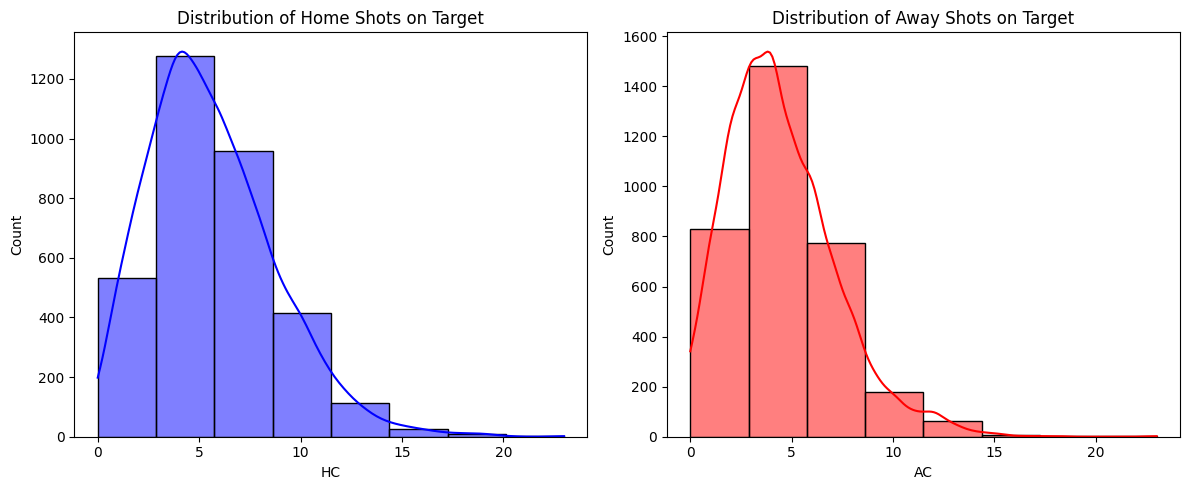

4.900217731261289


In [628]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['HC'], bins=8, kde=True, color='blue')
plt.title('Distribution of Home Shots on Target')

plt.subplot(1, 2, 2)
sns.histplot(df['AC'], bins=8, kde=True, color='red')
plt.title('Distribution of Away Shots on Target')

plt.tight_layout()
plt.show()


attack_home_avg = df.groupby('HomeTeam')['HC'].mean()
attack_away_avg = df.groupby('AwayTeam')['AC'].mean()
overall_attack_avg = pd.concat([attack_home_avg, attack_away_avg]).mean()
print(overall_attack_avg)

In [629]:
df['BTTS'] = ((df['FTHG'] >= 1) & (df['FTAG'] >= 1)).astype(int)

In [630]:
from sklearn.model_selection import train_test_split
# Features: You can choose relevant features. For simplicity, let's assume we use HomeTeam and AwayTeam.
# In practice, include more informative features as needed.
features = ['HomeTeam', 'AwayTeam']

# Encode categorical features using one-hot encoding or similar
X = pd.get_dummies(df[features], drop_first=True)
y = df['BTTS']

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.2, random_state=42, stratify=y
) 

In [631]:
def dc_decay(xi, t):
    return np.exp(-xi * t)

In [632]:
def rho_correction(goals_home, goals_away, home_exp, away_exp, rho):
    if goals_home == 0 and goals_away == 0:
        return 1 - (home_exp * away_exp * rho)
    elif goals_home == 0 and goals_away == 1:
        return 1 + (home_exp * rho)
    elif goals_home == 1 and goals_away == 0:
        return 1 + (away_exp * rho)
    elif goals_home == 1 and goals_away == 1:
        return 1 - rho
    else:
        return 1.0

In [633]:
def log_likelihood(
    goals_home_observed,
    goals_away_observed,
    home_attack,
    home_defence,
    away_attack,
    away_defence,
    home_advantage,
    rho,
    weight
):
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)

    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)
    adj_llk = rho_correction(   
        goals_home_observed,
        goals_away_observed,
        goal_expectation_home,
        goal_expectation_away,
        rho,
    )

    if goal_expectation_home < 0 or goal_expectation_away < 0 or adj_llk < 0:
        return 10000
    epsilon = 1e-10
    log_llk = weight * (np.log(home_llk + epsilon) + np.log(away_llk + epsilon) + np.log(adj_llk + epsilon))
    return -log_llk

In [635]:
from pprint import pprint
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson
def fit_poisson_model(xi=0.00018):
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)
    
     #Convert the Date column to datetime with the specific format
    df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y', errors='coerce')

    # Check for any NaT values in Date after conversion
    if df["Date"].isnull().any():
        print("Warning: There are rows with invalid date formats.")

    # Calculate the days since the maximum date
    df["days_since"] = (df["Date"].max() - df["Date"]).dt.days
    df["weight"] = dc_decay(xi, df["days_since"])


    params = np.concatenate(
        (
            np.random.uniform(0.5, 1.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
            [-0.1],  # rho
        )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-2]
        rho = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
                rho,
                row["weight"],
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv", "rho"],
            res["x"],
        )
    )

    return model_params

In [636]:
model_params = fit_poisson_model()
pprint(model_params)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\1966594622.py:12: RuntimeWarning: overflow encountered in exp
  goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_discrete_distns.py:863: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\1966594622.py:13: RuntimeWarning: overflow encountered in exp
  goal_expectation_away = np.exp(away_attack + home_defence)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\621928624.py:3: RuntimeWarning: overflow encountered in scalar multiply
  return 1 - (home_exp * away_exp * rho)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\621928624.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (home_exp * away_exp * rho)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

def predict(params, home_team, away_team):
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]
    rho = params["rho"]

    # Calculate expected goals using exponential to ensure positivity
    home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_goal_expectation = np.exp(away_attack + home_defence)

    # Poisson probabilities for goals from 0 to 9
    max_goals = 9
    goal_range = np.arange(0, max_goals + 1)
    home_probs = poisson.pmf(goal_range, home_goal_expectation)
    away_probs = poisson.pmf(goal_range, away_goal_expectation)

    # Goal probability matrix (Home Goals x Away Goals)
    m = np.outer(home_probs, away_probs)
    
    # Adjust for correlation (if rho is used in your model)
    if rho != 0:
        m[0, 0] *= 1 - home_goal_expectation * away_goal_expectation * rho
        m[0, 1] *= 1 + home_goal_expectation * rho
        m[1, 0] *= 1 + away_goal_expectation * rho
        m[1, 1] *= 1 - rho    
    
    # Ensure the matrix sums to 1 after adjustments
    m = m / m.sum()

    # Calculate both teams to score (BTTS) probability
    p_home_zero = home_probs[0]       # P(Home = 0)
    p_away_zero = away_probs[0]       # P(Away = 0)
    p_both_score = 1 - (p_home_zero + p_away_zero - m[0, 0])
    print(f'{home_team} VS {away_team} Cheat Sheet')
    print('============================================================')
    print(f'Both Teams To Score (BTTS) Probability: {p_both_score:.4f}')
    print(f'BTTS Odds: {1/p_both_score:.4f}')

    # Optional: Plotting the goal probability matrix
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(m, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Probability')
    plt.xlabel("Away Goals")
    plt.ylabel("Home Goals")
    plt.title("Goal Probability Matrix (m)")

    # Display the values in each cell
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, f"{m[i, j]:.2f}", ha='center', va='center', color="black")

    plt.show()
    """

    # Calculate match outcome probabilities
    home_win_prob = np.sum(np.tril(m, -1))
    draw_prob = np.sum(np.diag(m))
    away_win_prob = np.sum(np.triu(m, 1))

    # Calculate total goals probabilities
    max_total_goals = 2 * max_goals  # Maximum possible total goals
    total_goals_probs = np.zeros(max_total_goals + 1)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            total_goals = i + j
            total_goals_probs[total_goals] += m[i, j]

    # Calculate over/under probabilities for total goals
    def over_under_total_prob(threshold):
        under_prob = np.sum(total_goals_probs[:int(np.floor(threshold)) + 1])
        over_prob = 1 - under_prob
        return under_prob, over_prob

    total_thresholds = [1.5, 2.5, 3.5]
    over_under_total_results = {}
    for threshold in total_thresholds:
        under_prob, over_prob = over_under_total_prob(threshold)
        over_under_total_results[threshold] = {
            'Under': under_prob,
            'Over': over_prob
        }
        print(f"Under {threshold} total goals: {under_prob:.4f}, Over {threshold} total goals: {over_prob:.4f}")

    # Calculate over/under probabilities for individual team goals
    def over_under_team_prob(probs, threshold):
        # Under probability: P(goals <= floor(threshold))
        under_prob = np.sum(probs[:int(np.floor(threshold)) + 1])
        over_prob = 1 - under_prob
        return under_prob, over_prob

    team_thresholds = [0.5, 1.5, 2.5, 3.5]
    over_under_team_results = {home_team: {}, away_team: {}}

    for threshold in team_thresholds:
        # Home team over/under
        under_prob_home, over_prob_home = over_under_team_prob(home_probs, threshold)
        over_under_team_results[home_team][threshold] = {
            'Under': under_prob_home,
            'Over': over_prob_home
        }

        # Away team over/under
        under_prob_away, over_prob_away = over_under_team_prob(away_probs, threshold)
        over_under_team_results[away_team][threshold] = {
            'Under': under_prob_away,
            'Over': over_prob_away
        }

    # Calculate probabilities for goal ranges
    goal_ranges = {
        '0-2 Goals': (0, 2),
        '1-3 Goals': (1, 3),
        '1-4 Goals': (1, 4),
        '2-3 Goals': (2, 3),
        '2-4 Goals': (2, 4),
        '4+ Goals': (4, max_total_goals)
    }

    goal_range_probs = {}
    for range_name, (start, end) in goal_ranges.items():
        # For '4+ Goals', we need to include all goals from 4 to max_total_goals
        if end == max_total_goals:
            prob = np.sum(total_goals_probs[start:])
        else:
            prob = np.sum(total_goals_probs[start:end + 1])
        goal_range_probs[range_name] = prob

    # Display goal range probabilities and odds
    print("\nGoal Range Probabilities and Odds:")
    for range_name, prob in goal_range_probs.items():
        odds = 1 / (prob + 1e-8)  # To prevent division by zero
        print(f"{range_name}: Probability = {prob:.4f}, Odds = {odds:.2f}")

    # Calculate Odds
    def calculate_odds(prob):
        epsilon = 1e-8  # To prevent division by zero
        return 1 / (prob + epsilon)

    # Match outcome odds
    home_win_odds = calculate_odds(home_win_prob)
    draw_odds = calculate_odds(draw_prob)
    away_win_odds = calculate_odds(away_win_prob)

    print("\nMatch Outcome Odds (Decimal):")
    print(f"Home Win: {home_win_odds:.2f}")
    print(f"Draw: {draw_odds:.2f}")
    print(f"Away Win: {away_win_odds:.2f}")

    # Over/Under odds for total goals
    print("\nOver/Under Total Goals Odds (Decimal):")
    for threshold in total_thresholds:
        under_odds = calculate_odds(over_under_total_results[threshold]['Under'])
        over_odds = calculate_odds(over_under_total_results[threshold]['Over'])
        print(f"Under {threshold} total goals: {under_odds:.2f}, Over {threshold} total goals: {over_odds:.2f}")

    # Over/Under odds for individual team goals
    print("\nOver/Under Goals Odds per Team (Decimal):")
    for team in [home_team, away_team]:
        print(f"\n{team}:")
        for threshold in team_thresholds:
            under_prob = over_under_team_results[team][threshold]['Under']
            over_prob = over_under_team_results[team][threshold]['Over']
            under_odds = calculate_odds(under_prob)
            over_odds = calculate_odds(over_prob)
            print(f"  Under {threshold} goals: {under_odds:.2f}, Over {threshold} goals: {over_odds:.2f}")

    return home_win_prob, draw_prob, away_win_prob, over_under_total_results, over_under_team_results, goal_range_probs


In [ ]:
from pprint import pprint
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson


def fit_poisson_model_ST(df,xi=0.001):
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)

    # Convert the Date column to datetime with the specific format
    df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y', errors='coerce')

    # Check for any NaT values in Date after conversion
    if df["Date"].isnull().any():
        print("Warning: There are rows with invalid date formats.")

    # Calculate the days since the maximum date
    df["days_since"] = (df["Date"].max() - df["Date"]).dt.days
    df["weight"] = dc_decay(xi, df["days_since"])

    params = np.concatenate(
        (
            np.random.uniform(0.3, 2, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
            [-0.1],  # rho
        )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-2]
        rho = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["HST"],
                row["AST"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
                rho,
                row["weight"],
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 500,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv", "rho"],
            res["x"],
        )
    )

    return model_params

In [ ]:
model_params_ST = fit_poisson_model_ST(df_train)
pprint(model_params_ST)

In [517]:
from pprint import pprint
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson


def fit_poisson_model_C(df,xi=0.0018):
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)

    # Convert the Date column to datetime with the specific format
    df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y', errors='coerce')

    # Check for any NaT values in Date after conversion
    if df["Date"].isnull().any():
        print("Warning: There are rows with invalid date formats.")

    # Calculate the days since the maximum date
    df["days_since"] = (df["Date"].max() - df["Date"]).dt.days
    df["weight"] = dc_decay(xi, df["days_since"])

    params = np.concatenate(
        (
            np.random.uniform(0.5, 2.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
            [-0.1],  # rho
        )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-2]
        rho = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["HC"],
                row["AC"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
                rho,
                row["weight"],
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 500,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv", "rho"],
            res["x"],
        )
    )

    return model_params

In [518]:
model_params_C = fit_poisson_model_ST(df_train)
pprint(model_params_C)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\3661678568.py:12: RuntimeWarning: overflow encountered in exp
  goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_discrete_distns.py:863: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\3661678568.py:13: RuntimeWarning: overflow encountered in exp
  goal_expectation_away = np.exp(away_attack + home_defence)
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_discrete_distns.py:863: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\3661678568.py:12: RuntimeWarning: overflow encountered in exp
  goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
C:\Users\ahmed\AppData\

{'attack_Arsenal': 1.2368615904702465,
 'attack_Aston Villa': 1.0666488747343512,
 'attack_Bournemouth': 1.0189924611292653,
 'attack_Brentford': 0.9956323853125625,
 'attack_Brighton': 1.1866237268468676,
 'attack_Burnley': 0.793882335005613,
 'attack_Chelsea': 1.176657194899786,
 'attack_Crystal Palace': 0.95162183109455,
 'attack_Everton': 0.9457085700054728,
 'attack_Fulham': 0.9785035309320695,
 'attack_Leeds': 0.9907262424553316,
 'attack_Leicester': 1.0744884099872023,
 'attack_Liverpool': 1.4604010176119497,
 'attack_Luton': 0.8425759474837294,
 'attack_Man City': 1.3874455854573986,
 'attack_Man United': 1.2145340524715067,
 'attack_Newcastle': 1.139558216267495,
 'attack_Norwich': 0.5951967459796513,
 "attack_Nott'm Forest": 0.7239896360173812,
 'attack_Sheffield United': 0.7319350214670522,
 'attack_Southampton': 1.0378352729257654,
 'attack_Tottenham': 1.2141188928144917,
 'attack_Watford': 0.8200592412289482,
 'attack_West Brom': 0.5284464550573031,
 'attack_West Ham': 0.9

In [600]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

def predict_ST(params, home_team, away_team):
    """
    Predicts the number of shots for home and away teams using a Poisson model,
    calculates probabilities for over/under shot thresholds, and determines
    which team is more likely to have more shots.

    Parameters:
    - params (dict): Model parameters including attack and defence strengths,
                     home advantage, and rho for correlation.
    - home_team (str): Name of the home team.
    - away_team (str): Name of the away team.

    Returns:
    - home_shots_prob (float): Probability of home team winning in shots.
    - draw_shots_prob (float): Probability of a draw in shots.
    - away_shots_prob (float): Probability of away team winning in shots.
    - over_under_shots_team (dict): Over/Under probabilities for specified thresholds per team.
    - over_under_shots_total (dict): Over/Under probabilities for specified thresholds total shots.
    """
    # Extract parameters
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]
    rho = params["rho"]  # Correlation parameter for shots

    # Calculate expected shots using exponential to ensure positivity
    home_shot_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_shot_expectation = np.exp(away_attack + home_defence)

    # Poisson probabilities for shots from 0 to 25 (adjust as needed)
    max_shots = 20
    home_probs = poisson.pmf(range(max_shots + 1), home_shot_expectation)
    away_probs = poisson.pmf(range(max_shots + 1), away_shot_expectation)

    # Shot probability matrix (Home Shots x Away Shots)
    m = np.outer(home_probs, away_probs)

    # Adjust for correlation (rho)
    # This simplistic adjustment modifies the (0,0), (0,1), (1,0), and (1,1) cells.
    # For a more accurate correlation adjustment, consider more sophisticated methods.
    if rho != 0:
        m[0, 0] *= 1 - home_shot_expectation * away_shot_expectation * rho
        m[0, 1] *= 1 + home_shot_expectation * rho
        m[1, 0] *= 1 + away_shot_expectation * rho
        m[1, 1] *= 1 - rho

    # Ensure all probabilities are non-negative and normalize
    m = np.maximum(m, 0)
    m /= m.sum()

    # Calculate Dominant Shot Probabilities
    home_shots_prob = np.sum(np.tril(m, -1))  # Home shots > Away shots
    draw_shots_prob = np.sum(np.diag(m))      # Home shots == Away shots
    away_shots_prob = np.sum(np.triu(m, 1))   # Away shots > Home shots

    # Print Cheat Sheet
    print(f'{home_team} VS {away_team} - Shots Prediction Cheat Sheet')
    print('============================================================')
    print(f'Probability {home_team} has more shots: {home_shots_prob:.4f}')
    print(f'Probability of a draw in shots: {draw_shots_prob:.4f}')
    print(f'Probability {away_team} has more shots: {away_shots_prob:.4f}')

    # Calculate Over/Under Shot Probabilities for Each Team
    def over_under_team_prob(probs, threshold):
        # Under probability: P(shots <= threshold)
        under_prob = np.sum(probs[:int(threshold)+1])
        over_prob = 1 - under_prob
        return under_prob, over_prob

    # Individual team shot thresholds
    team_shot_thresholds = [3, 5, 7, 9]  # Adjust thresholds as needed
    over_under_shots_team = {home_team: {}, away_team: {}}

    print("\nOver/Under Shots Per Team:")
    for threshold in team_shot_thresholds:
        # Home team probabilities
        under_prob_home, over_prob_home = over_under_team_prob(home_probs, threshold)
        over_under_shots_team[home_team][threshold] = {
            'Under': under_prob_home,
            'Over': over_prob_home
        }

        # Away team probabilities
        under_prob_away, over_prob_away = over_under_team_prob(away_probs, threshold)
        over_under_shots_team[away_team][threshold] = {
            'Under': under_prob_away,
            'Over': over_prob_away
        }

        print(f"\nThreshold {threshold} Shots:")
        print(f"{home_team} - Under {threshold} shots: {under_prob_home:.4f}, Over {threshold} shots: {over_prob_home:.4f}")
        print(f"{away_team} - Under {threshold} shots: {under_prob_away:.4f}, Over {threshold} shots: {over_prob_away:.4f}")

    # Calculate Over/Under Shot Probabilities for Total Shots
    def over_under_total_prob(m, threshold):
        total_probs = np.zeros((max_shots * 2) + 1)
        for i in range(max_shots + 1):
            for j in range(max_shots + 1):
                total_probs[i + j] += m[i, j]
        # Under probability: P(total shots <= threshold)
        under_prob = np.sum(total_probs[:int(threshold)+1])
        over_prob = 1 - under_prob
        return under_prob, over_prob

    # Total shots thresholds
    total_shot_thresholds = [5, 7, 9, 11]  # Adjust thresholds as needed
    over_under_shots_total = {}
    print("\nOver/Under Total Shots:")
    for threshold in total_shot_thresholds:
        under_prob_total, over_prob_total = over_under_total_prob(m, threshold)
        over_under_shots_total[threshold] = {
            'Under': under_prob_total,
            'Over': over_prob_total
        }
        print(f"Under {threshold} total shots: {under_prob_total:.4f}, Over {threshold} total shots: {over_prob_total:.4f}")

    # Calculate Betting Odds
    def calculate_odds(prob):
        epsilon = 1e-8  # To prevent division by zero
        return 1 / (prob + epsilon)

    # Match outcome odds based on shots
    home_shots_odds = calculate_odds(home_shots_prob)
    draw_shots_odds = calculate_odds(draw_shots_prob)
    away_shots_odds = calculate_odds(away_shots_prob)

    print("\nShot Outcome Odds (Decimal):")
    print(f"{home_team} More Shots: {home_shots_odds:.2f}")
    print(f"Draw in Shots: {draw_shots_odds:.2f}")
    print(f"{away_team} More Shots: {away_shots_odds:.2f}")

    # Over/Under odds for shots per team
    print("\nOver/Under Odds Per Team:")
    for threshold in team_shot_thresholds:
        # Home team odds
        under_odds_home = calculate_odds(over_under_shots_team[home_team][threshold]['Under'])
        over_odds_home = calculate_odds(over_under_shots_team[home_team][threshold]['Over'])

        # Away team odds
        under_odds_away = calculate_odds(over_under_shots_team[away_team][threshold]['Under'])
        over_odds_away = calculate_odds(over_under_shots_team[away_team][threshold]['Over'])

        print(f"\nThreshold {threshold} Shots:")
        print(f"{home_team} - Under {threshold} shots: {under_odds_home:.2f}, Over {threshold} shots: {over_odds_home:.2f}")
        print(f"{away_team} - Under {threshold} shots: {under_odds_away:.2f}, Over {threshold} shots: {over_odds_away:.2f}")

    # Over/Under odds for total shots
    print("\nOver/Under Odds for Total Shots:")
    for threshold in total_shot_thresholds:
        under_odds_total = calculate_odds(over_under_shots_total[threshold]['Under'])
        over_odds_total = calculate_odds(over_under_shots_total[threshold]['Over'])

        print(f"Under {threshold} total shots: {under_odds_total:.2f}, Over {threshold} total shots: {over_odds_total:.2f}")

    # Optional: Plotting the Shot Probability Matrix
    # Uncomment the following lines if you wish to visualize the shot probability matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(m, cmap='Greens', interpolation='nearest')
    plt.colorbar(label='Probability')
    plt.xlabel(f"{away_team} Shots")
    plt.ylabel(f"{home_team} Shots")
    plt.title(f"Shot Probability Matrix: {home_team} vs {away_team}")

    # Display the values in each cell (optional for large matrices, may clutter)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m[i, j] > 0.001:  # Only display significant probabilities
                plt.text(j, i, f"{m[i, j]:.3f}", ha='center', va='center', color="black", fontsize=6)

    plt.show()

    return home_shots_prob, draw_shots_prob, away_shots_prob, over_under_shots_team, over_under_shots_total


Man United VS Chelsea - Shots Prediction Cheat Sheet
Probability Man United has more shots: 0.6197
Probability of a draw in shots: 0.1071
Probability Chelsea has more shots: 0.2732

Over/Under Shots Per Team:

Threshold 3 Shots:
Man United - Under 3 shots: 0.1081, Over 3 shots: 0.8919
Chelsea - Under 3 shots: 0.2631, Over 3 shots: 0.7369

Threshold 5 Shots:
Man United - Under 5 shots: 0.3611, Over 5 shots: 0.6389
Chelsea - Under 5 shots: 0.6135, Over 5 shots: 0.3865

Threshold 7 Shots:
Man United - Under 7 shots: 0.6647, Over 7 shots: 0.3353
Chelsea - Under 7 shots: 0.8652, Over 7 shots: 0.1348

Threshold 9 Shots:
Man United - Under 9 shots: 0.8726, Over 9 shots: 0.1274
Chelsea - Under 9 shots: 0.9677, Over 9 shots: 0.0323

Over/Under Total Shots:
Under 5 total shots: 0.0269, Over 5 total shots: 0.9731
Under 7 total shots: 0.1103, Over 7 total shots: 0.8897
Under 9 total shots: 0.2823, Over 9 total shots: 0.7177
Under 11 total shots: 0.5118, Over 11 total shots: 0.4882

Shot Outcome Od

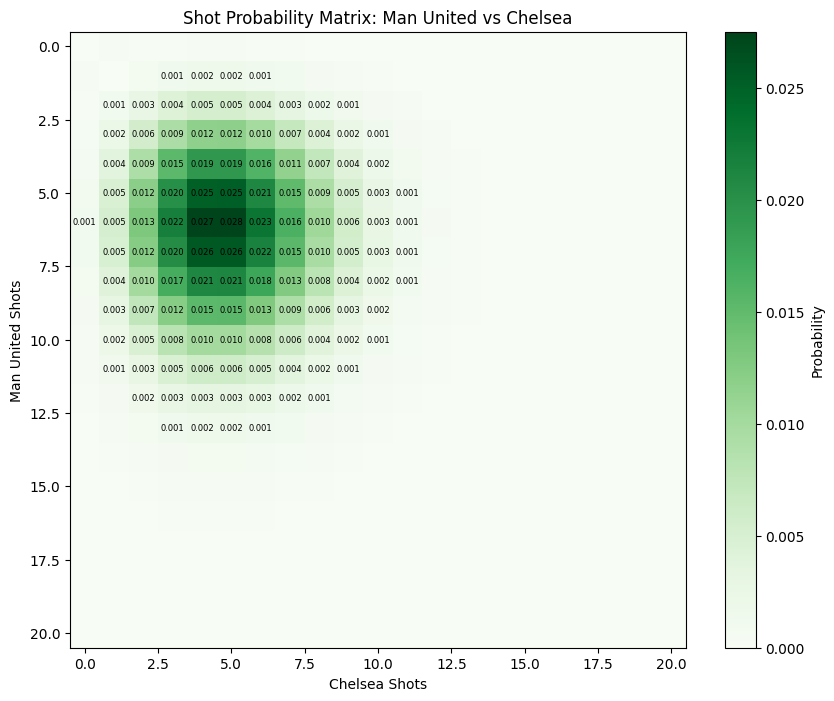

Man United VS Chelsea Cheat Sheet
Both Teams To Score (BTTS) Probability: 0.6405
BTTS Odds: 1.5612
Under 1.5 total goals: 0.1650, Over 1.5 total goals: 0.8350
Under 2.5 total goals: 0.3777, Over 2.5 total goals: 0.6223
Under 3.5 total goals: 0.6002, Over 3.5 total goals: 0.3998

Goal Range Probabilities and Odds:
0-2 Goals: Probability = 0.3777, Odds = 2.65
1-3 Goals: Probability = 0.5550, Odds = 1.80
1-4 Goals: Probability = 0.7335, Odds = 1.36
2-3 Goals: Probability = 0.4352, Odds = 2.30
2-4 Goals: Probability = 0.6138, Odds = 1.63
4+ Goals: Probability = 0.3998, Odds = 2.50

Match Outcome Odds (Decimal):
Home Win: 3.06
Draw: 4.14
Away Win: 2.32

Over/Under Total Goals Odds (Decimal):
Under 1.5 total goals: 6.06, Over 1.5 total goals: 1.20
Under 2.5 total goals: 2.65, Over 2.5 total goals: 1.61
Under 3.5 total goals: 1.67, Over 3.5 total goals: 2.50

Over/Under Goals Odds per Team (Decimal):

Man United:
  Under 0.5 goals: 4.41, Over 0.5 goals: 1.29
  Under 1.5 goals: 1.78, Over 1.5 

(0.3272588753495043,
 0.2417766372169749,
 0.43096448743352084,
 {1.5: {'Under': 0.16496748396261737, 'Over': 0.8350325160373826},
  2.5: {'Under': 0.3777020554220679, 'Over': 0.6222979445779321},
  3.5: {'Under': 0.600170795539879, 'Over': 0.39982920446012105}},
 {'Man United': {0.5: {'Under': 0.22684784363090463,
    'Over': 0.7731521563690954},
   1.5: {'Under': 0.5633711250899767, 'Over': 0.43662887491002333},
   2.5: {'Under': 0.812983193583436, 'Over': 0.18701680641656404},
   3.5: {'Under': 0.9364143461373613, 'Over': 0.0635856538626387}},
  'Chelsea': {0.5: {'Under': 0.17779461948151215, 'Over': 0.8222053805184879},
   1.5: {'Under': 0.4848683682063013, 'Over': 0.5151316317936987},
   2.5: {'Under': 0.7500459293464462, 'Over': 0.2499540706535538},
   3.5: {'Under': 0.9027109687693979, 'Over': 0.09728903123060206}}},
 {'0-2 Goals': 0.3777020554220679,
  '1-3 Goals': 0.5549789215689815,
  '1-4 Goals': 0.7335435668707035,
  '2-3 Goals': 0.43520331157726166,
  '2-4 Goals': 0.613767

In [604]:
# predict(model_params,"Liverpool",'Brighton')
# predict(model_params,"Bournemouth",'Man City')
#predict(model_params,"Ipswich",'Leicester')
predict_ST(model_params_ST,"Man United",'Chelsea')
predict(model_params,'Man United', 'Chelsea')

In [ ]:

# Assuming you have a DataFrame 'matches_df' with historical match data
# Columns: 'HomeTeam', 'AwayTeam', 'HomeShots', 'AwayShots'

def evaluate_model(matches_df, params):
    correct_predictions = 0
    total_matches = len(matches_df)
    
    # For Brier Score
    brier_home = []
    brier_draw = []
    brier_away = []
    
    # For Log Loss
    log_loss = 0
    epsilon = 1e-15  # To prevent log(0)
    
    for index, row in matches_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        actual_home_shots = row['HST']
        actual_away_shots = row['AST']
        
        # Get predicted probabilities
        home_prob, draw_prob, away_prob = predict_ST(params, home_team, away_team)
        
        # Determine predicted outcome
        if home_prob > away_prob and home_prob > draw_prob:
            predicted_outcome = 'Home'
            print(home_prob)
        elif away_prob > home_prob and away_prob > draw_prob:
            predicted_outcome = 'Away'
            print(away_prob)
        else:
            
            predicted_outcome = 'Draw'
        
        # Determine actual outcome
        if actual_home_shots > actual_away_shots:
            actual_outcome = 'Home'
        elif actual_away_shots > actual_home_shots:
            actual_outcome = 'Away'
        else:
            actual_outcome = 'Draw'
        
        # Check if prediction is correct
        if predicted_outcome == actual_outcome:
            correct_predictions += 1
        
        
        # Update Log Loss
        if actual_outcome == 'Home':
            log_loss += -np.log(home_prob + epsilon)
        elif actual_outcome == 'Draw':
            log_loss += -np.log(draw_prob + epsilon)
        else:
            log_loss += -np.log(away_prob + epsilon)
    
    # Calculate Metrics
    accuracy = correct_predictions / total_matches
    average_log_loss = log_loss / total_matches
    
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Average Log Loss: {average_log_loss:.4f}")
    
    return accuracy, average_log_loss

# Example usage:
# matches_df = pd.read_csv('historical_matches.csv')  # Ensure your CSV has the required columns
# evaluate_model(matches_df, params)


In [463]:
import numpy as np
import pandas as pd

def evaluate_model_high_confidence(matches_df, params, confidence_threshold=0.95):
    """
    Evaluates the accuracy and log loss of predictions when the predicted outcome probability exceeds a specified confidence threshold.

    Parameters:
    - matches_df (pd.DataFrame): DataFrame containing match data with columns ['HomeTeam', 'AwayTeam', 'HST', 'AST'].
    - params (dict): Dictionary of model parameters.
    - confidence_threshold (float): The minimum probability required to consider a prediction (default is 0.7).

    Returns:
    - overall_accuracy (float): Accuracy across all matches.
    - overall_log_loss (float): Log loss across all matches.
    - high_conf_accuracy (float): Accuracy for high-confidence predictions.
    - high_conf_log_loss (float): Log loss for high-confidence predictions.
    - high_conf_count (int): Number of high-confidence predictions.
    """
    correct_predictions = 0
    total_matches = len(matches_df)

    # For overall Log Loss
    overall_log_loss = 0
    epsilon = 1e-15  # To prevent log(0)

    # For high-confidence predictions
    high_conf_correct = 0
    high_conf_log_loss = 0
    high_conf_count = 0

    for index, row in matches_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        actual_home_shots = row['HST']
        actual_away_shots = row['AST']

        # Get predicted probabilities
        home_prob, draw_prob, away_prob,_ = predict_ST(params, home_team, away_team)

        # Determine predicted outcome
        if home_prob > away_prob and home_prob > draw_prob:
            predicted_outcome = 'Home'
            predicted_prob = home_prob
        elif away_prob > home_prob and away_prob > draw_prob:
            predicted_outcome = 'Away'
            predicted_prob = away_prob
        else:
            predicted_outcome = 'Draw'
            predicted_prob = draw_prob

        # Determine actual outcome
        if actual_home_shots > actual_away_shots:
            actual_outcome = 'Home'
        elif actual_away_shots > actual_home_shots:
            actual_outcome = 'Away'
        else:
            actual_outcome = 'Draw'

        # Check if prediction is correct
        if predicted_outcome == actual_outcome:
            correct_predictions += 1

        # Update overall Log Loss
        if actual_outcome == 'Home':
            overall_log_loss += -np.log(home_prob + epsilon)
        elif actual_outcome == 'Draw':
            overall_log_loss += -np.log(draw_prob + epsilon)
        else:
            overall_log_loss += -np.log(away_prob + epsilon)

        # High-confidence prediction check
        if predicted_prob >= confidence_threshold:
            high_conf_count += 1
            if predicted_outcome == actual_outcome:
                high_conf_correct += 1

            # Update high-confidence Log Loss
            if actual_outcome == 'Home':
                high_conf_log_loss += -np.log(home_prob + epsilon)
            elif actual_outcome == 'Draw':
                high_conf_log_loss += -np.log(draw_prob + epsilon)
            else:
                high_conf_log_loss += -np.log(away_prob + epsilon)

    # Calculate overall metrics
    overall_accuracy = correct_predictions / total_matches
    average_overall_log_loss = overall_log_loss / total_matches

    # Calculate high-confidence metrics
    if high_conf_count > 0:
        high_conf_accuracy = high_conf_correct / high_conf_count
        average_high_conf_log_loss = high_conf_log_loss / high_conf_count
    else:
        high_conf_accuracy = None
        average_high_conf_log_loss = None

    # Print Results
    print(f"Overall Accuracy: {overall_accuracy:.2%}")
    print(f"Overall Average Log Loss: {average_overall_log_loss:.4f}")
    if high_conf_count > 0:
        print(f"\nHigh-Confidence Predictions (≥ {confidence_threshold*100:.0f}%): {high_conf_count}")
        print(f"High-Confidence Accuracy: {high_conf_accuracy:.2%}")
        print(f"High-Confidence Average Log Loss: {average_high_conf_log_loss:.4f}")
    else:
        print(f"\nNo predictions met the high-confidence threshold of {confidence_threshold*100:.0f}%.")

    return overall_accuracy, average_overall_log_loss, high_conf_accuracy, average_high_conf_log_loss, high_conf_count

# Example usage:
# matches_df = pd.read_csv('historical_matches.csv')  # Ensure your CSV has the required columns: ['HomeTeam', 'AwayTeam', 'HST', 'AST']
# params = { ... }  # Your model parameters
# evaluate_model_high_confidence(matches_df, params, confidence_threshold=0.7)


In [464]:
import numpy as np
import pandas as pd

def evaluate_over_under(matches_df, params, shot_thresholds=[5.5, 7.5, 9.5, 11.5]):
    """
    Evaluates the accuracy and log loss of over/under shot predictions for specified thresholds.
    
    Parameters:
    - matches_df (pd.DataFrame): DataFrame containing match data with columns ['HomeTeam', 'AwayTeam', 'HST', 'AST'].
    - params (dict): Dictionary of model parameters.
    - shot_thresholds (list): List of shot thresholds to evaluate.
    
    Returns:
    - results (dict): Dictionary containing evaluation metrics for each threshold.
    """
    # Initialize metrics storage
    results = {}
    epsilon = 1e-15  # To prevent log(0)
    
    for threshold in shot_thresholds:
        correct_predictions = 0
        total_predictions = 0
        log_loss = 0.0
        brier_score = 0.0
        
        for index, row in matches_df.iterrows():
            home_team = row['HomeTeam']
            away_team = row['AwayTeam']
            actual_home_shots = row['HST']
            actual_away_shots = row['AST']
            
            # Calculate total shots
            total_shots = actual_home_shots + actual_away_shots
            
            # Determine actual outcome
            actual_outcome = 'Over' if total_shots > threshold else 'Under'
            
            # Get predicted probabilities
            home_prob, draw_prob, away_prob, over_under_shots = predict_ST(params, home_team, away_team)
            
            # Get model's over/under probabilities for the current threshold
            if threshold not in over_under_shots:
                print(f"Threshold {threshold} not found in over_under_shots. Skipping.")
                continue
            
            over_prob = over_under_shots[threshold]['Over']
            under_prob = over_under_shots[threshold]['Under']
            
            # Make prediction based on higher probability
            predicted_outcome = 'Over' if over_prob > under_prob else 'Under'
            predicted_prob = over_prob if over_prob > under_prob else under_prob
            
            # Update total predictions
            total_predictions += 1
            
            # Check if prediction is correct
            if predicted_outcome == actual_outcome:
                correct_predictions += 1
            
            # Update Log Loss
            if actual_outcome == 'Over':
                log_loss += -np.log(over_prob + epsilon)
            else:
                log_loss += -np.log(under_prob + epsilon)
            
            # Update Brier Score
            y = 1 if actual_outcome == 'Over' else 0
            p = over_prob  # Probability of "Over"
            brier_score += (p - y) ** 2
        
        # Calculate metrics
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else None
        average_log_loss = log_loss / total_predictions if total_predictions > 0 else None
        average_brier_score = brier_score / total_predictions if total_predictions > 0 else None
        
        # Store results
        results[threshold] = {
            'Accuracy': accuracy,
            'Average Log Loss': average_log_loss,
            'Average Brier Score': average_brier_score,
            'Total Predictions': total_predictions
        }
        
        # Print results for the threshold
        print(f"Threshold: {threshold} Shots")
        print(f"Accuracy: {accuracy:.2%}" if accuracy is not None else "Accuracy: N/A")
        print(f"Average Log Loss: {average_log_loss:.4f}" if average_log_loss is not None else "Average Log Loss: N/A")
        print(f"Average Brier Score: {average_brier_score:.4f}" if average_brier_score is not None else "Average Brier Score: N/A")
        print(f"Total Predictions: {total_predictions}\n")
    
    return results


In [476]:
import numpy as np
import pandas as pd

def evaluate_over_under_confidence(matches_df, params, shot_thresholds=[5.5, 7.5, 9.5, 11.5], confidence_threshold=0.90):
    """
    Evaluates the accuracy, log loss, and Brier score of over/under shot predictions
    individually for "Over" and "Under" when the predicted outcome probability exceeds a specified confidence threshold.
    
    Parameters:
    - matches_df (pd.DataFrame): DataFrame with columns ['HomeTeam', 'AwayTeam', 'HST', 'AST'].
    - params (dict): Model parameters.
    - shot_thresholds (list): List of shot thresholds to evaluate.
    - confidence_threshold (float): Minimum probability to consider a prediction as high-confidence.
    
    Returns:
    - results (dict): Dictionary containing metrics for each shot threshold and prediction type.
    """
    results = {}
    epsilon = 1e-15  # To prevent log(0)
    
    for threshold in shot_thresholds:
        # Initialize counters for Over and Under
        over_correct = 0
        over_total = 0
        over_log_loss = 0.0
        over_brier_score = 0.0
        
        under_correct = 0
        under_total = 0
        under_log_loss = 0.0
        under_brier_score = 0.0
        
        for index, row in matches_df.iterrows():
            home_team = row['HomeTeam']
            away_team = row['AwayTeam']
            actual_home_shots = row['HST']
            actual_away_shots = row['AST']
            
            # Calculate total shots
            total_shots = actual_home_shots + actual_away_shots
            
            # Determine actual outcome
            actual_outcome = 'Over' if total_shots > threshold else 'Under'
            
            # Get predicted probabilities
            home_prob, draw_prob, away_prob, over_under_shots = predict_ST(params, home_team, away_team)
            
            # Retrieve Over and Under probabilities for the current threshold
            if threshold not in over_under_shots:
                print(f"Threshold {threshold} not found in over_under_shots. Skipping match {home_team} vs {away_team}.")
                continue
            
            over_prob = over_under_shots[threshold]['Over']
            under_prob = over_under_shots[threshold]['Under']
            
            # Determine predicted outcome based on higher probability
            if over_prob > under_prob:
                predicted_outcome = 'Over'
                predicted_prob = over_prob
            else:
                predicted_outcome = 'Under'
                predicted_prob = under_prob
            
            # Apply confidence threshold
            if predicted_prob >= confidence_threshold:
                if predicted_outcome == 'Over':
                    over_total += 1
                    if actual_outcome == 'Over':
                        over_correct += 1
                    # Update Log Loss
                    over_log_loss += -np.log(over_prob + epsilon)
                    # Update Brier Score
                    y = 1 if actual_outcome == 'Over' else 0
                    p = over_prob
                    over_brier_score += (p - y) ** 2
                else:  # predicted_outcome == 'Under'
                    under_total += 1
                    if actual_outcome == 'Under':
                        under_correct += 1
                    # Update Log Loss
                    under_log_loss += -np.log(under_prob + epsilon)
                    # Update Brier Score
                    y = 1 if actual_outcome == 'Over' else 0  # For Under, y=0
                    p = over_prob  # Probability of Over
                    under_brier_score += (p - y) ** 2
        
        # Calculate Metrics for Over
        over_accuracy = over_correct / over_total if over_total > 0 else None
        average_over_log_loss = over_log_loss / over_total if over_total > 0 else None
        average_over_brier_score = over_brier_score / over_total if over_total > 0 else None
        
        # Calculate Metrics for Under
        under_accuracy = under_correct / under_total if under_total > 0 else None
        average_under_log_loss = under_log_loss / under_total if under_total > 0 else None
        average_under_brier_score = under_brier_score / under_total if under_total > 0 else None
        
        # Store results
        results[threshold] = {
            'Over': {
                'Accuracy': over_accuracy,
                'Average Log Loss': average_over_log_loss,
                'Average Brier Score': average_over_brier_score,
                'Total High-Confidence Over Predictions': over_total
            },
            'Under': {
                'Accuracy': under_accuracy,
                'Average Log Loss': average_under_log_loss,
                'Average Brier Score': average_under_brier_score,
                'Total High-Confidence Under Predictions': under_total
            }
        }
        
        # Print results for the threshold
        print(f"Threshold: {threshold} Shots")
        
        # Over Metrics
        if over_total > 0:
            print(f"  Over Predictions (≥ {confidence_threshold*100:.0f}% Confidence): {over_total}")
            print(f"    Accuracy: {over_accuracy*100:.2f}%")
            print(f"    Average Log Loss: {average_over_log_loss:.4f}")
            print(f"    Average Brier Score: {average_over_brier_score:.4f}")
        else:
            print(f"  No high-confidence Over predictions (≥ {confidence_threshold*100:.0f}%) for threshold {threshold}.")
        
        # Under Metrics
        if under_total > 0:
            print(f"  Under Predictions (≥ {confidence_threshold*100:.0f}% Confidence): {under_total}")
            print(f"    Accuracy: {under_accuracy*100:.2f}%")
            print(f"    Average Log Loss: {average_under_log_loss:.4f}")
            print(f"    Average Brier Score: {average_under_brier_score:.4f}")
        else:
            print(f"  No high-confidence Under predictions (≥ {confidence_threshold*100:.0f}%) for threshold {threshold}.")
        
        print("")  # Blank line for readability
    
    return results


Man City VS Crystal Palace - Shots Prediction Cheat Sheet
Probability Man City has more shots: 0.8211
Probability of a draw in shots: 0.0756
Probability Crystal Palace has more shots: 0.1034

Over/Under Shots Per Team:

Threshold 3 Shots:
Man City - Under 3 shots: 0.1708, Over 3 shots: 0.8292
Crystal Palace - Under 3 shots: 0.7234, Over 3 shots: 0.2766

Threshold 5 Shots:
Man City - Under 5 shots: 0.4798, Over 5 shots: 0.5202
Crystal Palace - Under 5 shots: 0.9466, Over 5 shots: 0.0534

Threshold 7 Shots:
Man City - Under 7 shots: 0.7722, Over 7 shots: 0.2278
Crystal Palace - Under 7 shots: 0.9939, Over 7 shots: 0.0061

Threshold 9 Shots:
Man City - Under 9 shots: 0.9297, Over 9 shots: 0.0703
Crystal Palace - Under 9 shots: 0.9996, Over 9 shots: 0.0004

Over/Under Total Shots:
Under 5 total shots: 0.1561, Over 5 total shots: 0.8439
Under 7 total shots: 0.3941, Over 7 total shots: 0.6059
Under 9 total shots: 0.6606, Over 9 total shots: 0.3394
Under 11 total shots: 0.8534, Over 11 total 

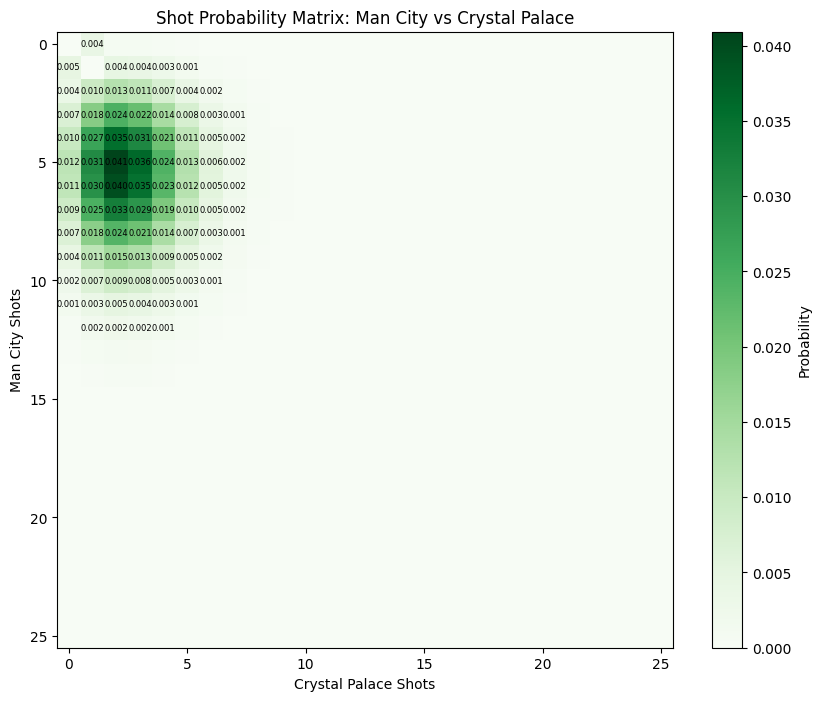

ValueError: too many values to unpack (expected 4)

In [549]:
#evaluate_model_high_confidence(df_test, model_params_ST)
evaluate_over_under_confidence(df_test, model_params_ST)

In [ ]:
from pprint import pprint
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson


def fit_poisson_model(xi=0.001):
    teams = np.sort(np.unique(np.concatenate([df_train["HomeTeam"], df_train["AwayTeam"]])))
    n_teams = len(teams)

    # Convert the Date column to datetime with the specific format
    df_train["Date"] = pd.to_datetime(df_train["Date"], format='%d/%m/%Y', errors='coerce')

    # Check for any NaT values in Date after conversion
    if df["Date"].isnull().any():
        print("Warning: There are rows with invalid date formats.")

    # Calculate the days since the maximum date
    df_train["days_since"] = (df_train["Date"].max() - df_train["Date"]).dt.days
    df_train["weight"] = dc_decay(xi, df_train["days_since"])

    params = np.concatenate(
        (
            np.random.uniform(0.5, 1.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
            [-0.1],  # rho
        )
    )

    def _fit(params, df_train, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-2]
        rho = params[-1]

        llk = list()
        for idx, row in df_train.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
                rho,
                row["weight"],
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df_train, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv", "rho"],
            res["x"],
        )
    )

    return model_params

In [333]:
model_params = fit_poisson_model()
pprint(model_params)

{'attack_Arsenal': 1.4385289824970355,
 'attack_Aston Villa': 1.2285737488959847,
 'attack_Bournemouth': 0.9597869011545616,
 'attack_Brentford': 1.0690885644518395,
 'attack_Brighton': 1.1334523596840467,
 'attack_Burnley': 0.7037987899429756,
 'attack_Chelsea': 1.2089383779781224,
 'attack_Crystal Palace': 0.9145051165697041,
 'attack_Everton': 0.6953085880025285,
 'attack_Fulham': 0.9356285790705415,
 'attack_Ipswich': 0.9872021967832152,
 'attack_Leeds': 0.9900452826060678,
 'attack_Leicester': 1.1906018961803264,
 'attack_Liverpool': 1.5054752420530608,
 'attack_Luton': 1.0562132951223555,
 'attack_Man City': 1.6087061894151315,
 'attack_Man United': 1.143171426149182,
 'attack_Newcastle': 1.263985037837069,
 'attack_Norwich': 0.22626858451205004,
 "attack_Nott'm Forest": 0.8986171033758754,
 'attack_Sheffield United': 0.40381163998534414,
 'attack_Southampton': 0.7690868968215323,
 'attack_Tottenham': 1.379953347871795,
 'attack_Watford': 0.673086745965945,
 'attack_West Brom': 0

In [ ]:
predict(model_params,"Liverpool",'Brighton')
predict(model_params,"Bournemouth",'Man City')
predict(model_params,"Ipswich",'Leicester')

In [265]:
model_params = fit_poisson_model()
pprint(model_params)


C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\807300152.py:12: RuntimeWarning: overflow encountered in exp
  goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_discrete_distns.py:863: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu


{'attack_Arsenal': 1.2223384985301238,
 'attack_Aston Villa': 1.0238028334366187,
 'attack_Bournemouth': 1.0617422718024343,
 'attack_Brentford': 1.0390542015088875,
 'attack_Brighton': 1.1227637165496527,
 'attack_Burnley': 0.8225407276323742,
 'attack_Chelsea': 1.225706021478085,
 'attack_Crystal Palace': 0.969591849539177,
 'attack_Everton': 0.8705893950106276,
 'attack_Fulham': 1.0100213212444942,
 'attack_Ipswich': 0.6558679936428714,
 'attack_Leicester': 0.5861095662570174,
 'attack_Liverpool': 1.420103990704216,
 'attack_Luton': 0.8145800906912773,
 'attack_Man City': 1.4287751311413606,
 'attack_Man United': 1.1351891949239183,
 'attack_Newcastle': 1.1310963959510565,
 "attack_Nott'm Forest": 0.9152745433003356,
 'attack_Sheffield United': 0.7308126713589094,
 'attack_Southampton': 0.7454929853011271,
 'attack_Tottenham': 1.2285003938128698,
 'attack_West Ham': 0.8996450554461658,
 'attack_Wolves': 0.9404011507363966,
 'defence_Arsenal': -0.1552674170282931,
 'defence_Aston Vil

Ipswich VS Leicester Cheat Sheet
Both Teams To Score (BTTS) Probability: 0.9601
BTTS Odds: 1.0416


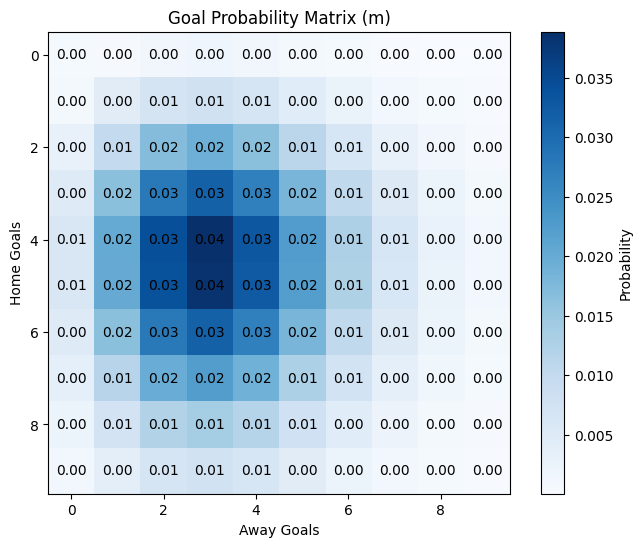

Under 1.5 goals: 0.0018, Over 1.5 goals: 0.9982
Under 2.5 goals: 0.0106, Over 2.5 goals: 0.9894
Under 3.5 goals: 0.0338, Over 3.5 goals: 0.9662

Match Outcome Odds (Decimal):
Home Win: 1.64
Draw: 8.09
Away Win: 4.25

Over/Under Goals Odds (Decimal):
Under 1.5 goals: 543.59, Over 1.5 goals: 1.00
Under 2.5 goals: 94.46, Over 2.5 goals: 1.01
Under 3.5 goals: 29.62, Over 3.5 goals: 1.03


(0.6091677934586947,
 0.12362748299438124,
 0.2350684518895278,
 {1.5: {'Under': 0.0018395985385444619, 'Over': 0.9981604014614556},
  2.5: {'Under': 0.010586164685263471, 'Over': 0.9894138353147365},
  3.5: {'Under': 0.033763822359197615, 'Over': 0.9662361776408024}})

In [ ]:
predict(model_params,"Ipswich",'Leicester')
# predict(model_params,"Bournemouth",'Man City')
# predict(model_params,"Ipswich",'Leicester')

In [502]:
def calculate_btts_probability(row, model_params):
    """
    Calculates the BTTS probability for a single match.
    
    Parameters:
    - row (Series): A row from the test DataFrame containing 'HomeTeam' and 'AwayTeam'.
    - model_params (dict): Fitted model parameters.
    
    Returns:
    - btts_prob (float): Probability that both teams score.
    """
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    # Extract model parameters
    attack_home = model_params["attack_" + home_team]
    defence_home = model_params["defence_" + home_team]
    attack_away = model_params["attack_" + away_team]
    defence_away = model_params["defence_" + away_team]
    home_advantage = model_params["home_adv"]
    rho = model_params["rho"]  # Currently unused in independent assumption
    
    # Calculate expected goals using exponential to ensure positivity
    lambda_home = np.exp(attack_home + defence_away + home_advantage)
    lambda_away = np.exp(attack_away + defence_home)
    
    # Calculate probabilities of scoring at least one goal
    p_home = 1 - poisson.pmf(0, lambda_home)
    p_away = 1 - poisson.pmf(0, lambda_away)
    
    # Assuming independence
    btts_prob = p_home * p_away
    
    return btts_prob


In [503]:
# Add BTTS probability to the test set
df5 = df5.copy()  # To avoid SettingWithCopyWarning
df5['BTTS_Prob'] = df5.apply(lambda row: calculate_btts_probability(row, model_params), axis=1)


In [508]:
# Threshold for BTTS probability
threshold = 0.5

# Filter matches with BTTS probability > threshold
high_btts_matches = df5[df5['BTTS_Prob'] > threshold]


In [509]:
print(len(df5))
# Calculate actual BTTS in high probability matches
high_btts_matches['Actual_BTTS'] = ((high_btts_matches['FTHG'] >= 1) & (high_btts_matches['FTAG'] >= 1)).astype(int)

# Number of high probability predictions
num_predictions = len(high_btts_matches)

# Number of correct predictions
num_correct = high_btts_matches['Actual_BTTS'].sum()

# Success rate
success_rate = num_correct / num_predictions if num_predictions > 0 else 0

# Results
print(f"Total Predictions (BTTS Prob > {threshold}): {num_predictions}")
print(f"Correct Predictions (Both Teams Scored): {num_correct}")
print(f"Success Rate: {success_rate:.2%}")


90
Total Predictions (BTTS Prob > 0.5): 76
Correct Predictions (Both Teams Scored): 49
Success Rate: 64.47%


C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\3095001770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_btts_matches['Actual_BTTS'] = ((high_btts_matches['FTHG'] >= 1) & (high_btts_matches['FTAG'] >= 1)).astype(int)


In [568]:
def calculate_o25_probability_independent(row, model_params):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    # Extract model parameters
    attack_home = model_params["attack_" + home_team]
    defence_home = model_params["defence_" + home_team]
    attack_away = model_params["attack_" + away_team]
    defence_away = model_params["defence_" + away_team]
    home_advantage = model_params["home_adv"]
    
    # Calculate expected goals
    lambda_home = np.exp(attack_home + defence_away + home_advantage)
    lambda_away = np.exp(attack_away + defence_home)
    
    # Sum Poisson parameters
    lambda_total = lambda_home + lambda_away
    
    # Probability of total goals <=2
    p_total_leq_2 = poisson.cdf(2, lambda_total)
    
    # Probability of total goals >2.5 (i.e., >=3)
    o25_prob = 1 - p_total_leq_2
    
    return o25_prob

In [569]:
df5['O25_Prob'] = df5.apply(lambda row: calculate_o25_probability_independent(row, model_params), axis=1)

In [ ]:
o25_threshold = 0.65
# Independent Poisson Backtesting
high_o25_matches = df5[df5['O25_Prob'] > o25_threshold]
high_o25_matches['Actual_O25'] = (high_o25_matches['FTHG'] + high_o25_matches['FTAG']) >= 3

C:\Users\ahmed\AppData\Local\Temp\ipykernel_13156\4032190465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_o25_matches['Actual_O25'] = (high_o25_matches['FTHG'] + high_o25_matches['FTAG']) >= 3


In [571]:
num_predictions = len(high_o25_matches)
num_correct = high_o25_matches['Actual_O25'].sum()
success_rate = num_correct / num_predictions if num_predictions > 0 else 0

print(f"\nTotal Predictions (O2.5 Prob > {o25_threshold}): {num_predictions}")
print(f"Correct Predictions (Over 2.5 Goals): {num_correct}")
print(f"Success Rate: {success_rate:.2%}")



Total Predictions (O2.5 Prob > 0.65): 33
Correct Predictions (Over 2.5 Goals): 22
Success Rate: 66.67%


In [577]:
import numpy as np
import pandas as pd

# Function to calculate the probability of Over 2.5 goals using an independent Poisson model
def calculate_o25_probability_independent(row, model_params):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    # Extract model parameters
    attack_home = model_params["attack_" + home_team]
    defence_home = model_params["defence_" + home_team]
    attack_away = model_params["attack_" + away_team]
    defence_away = model_params["defence_" + away_team]
    home_advantage = model_params["home_adv"]
    
    # Calculate expected goals
    lambda_home = np.exp(attack_home + defence_away + home_advantage)
    lambda_away = np.exp(attack_away + defence_home)
    
    # Sum Poisson parameters
    lambda_total = lambda_home + lambda_away
    
    # Probability of total goals <= 2
    p_total_leq_2 = poisson.cdf(2, lambda_total)
    
    # Probability of total goals > 2.5 (i.e., >= 3)
    o25_prob = 1 - p_total_leq_2
    
    return o25_prob

# Apply the function to calculate the probability of Over 2.5 goals for each match
df5['O25_Prob'] = df5.apply(lambda row: calculate_o25_probability_independent(row, model_params), axis=1)

# Set the confidence threshold
o25_threshold = 0.8  # 60%

# Filter matches where the model's probability exceeds the threshold
bet_matches = df5[df5['O25_Prob'] > o25_threshold].copy()

# Create 'Actual_O25' column indicating whether the actual total goals were 3 or more
bet_matches['Actual_O25'] = (bet_matches['FTHG'] + bet_matches['FTAG']) >= 3

# Ensure that 'B365>2.5' column is numeric and remove rows with missing odds
bet_matches['B365>2.5'] = pd.to_numeric(bet_matches['B365>2.5'], errors='coerce')
bet_matches = bet_matches.dropna(subset=['B365>2.5'])

# Function to calculate the net profit or loss for each bet
def calculate_bet_return(row):
    stake = 1  # £1 per bet
    odds = row['B365>2.5']
    if row['Actual_O25']:
        # Winning bet: Net profit is (odds - 1) * stake
        return (odds - 1) * stake
    else:
        # Losing bet: Net loss is the stake
        return -stake

# Apply the function to calculate the bet return for each match
bet_matches['Bet_Return'] = bet_matches.apply(calculate_bet_return, axis=1)

# Calculate summary statistics
total_bets = bet_matches.shape[0]
total_stake = total_bets * 1  # £1 per bet
total_return = bet_matches['Bet_Return'].sum()
net_profit = total_return
roi = net_profit / total_stake if total_stake > 0 else 0

# Calculate the number of bets won and lost
bets_won = bet_matches['Actual_O25'].sum()
bets_lost = total_bets - bets_won

# Print the results
print(f"Backtesting Results for Over 2.5 Goals Bets (Confidence > {o25_threshold*100:.0f}%):\n")
print(f"Total bets placed: {total_bets}")
print(f"Bets won: {int(bets_won)}")
print(f"Bets lost: {int(bets_lost)}")
print(f"Total amount staked: £{total_stake:.2f}")
print(f"Total return: £{total_return + total_stake:.2f}")
print(f"Net profit: £{net_profit:.2f}")
print(f"Return on Investment (ROI): {roi:.2%}")


Backtesting Results for Over 2.5 Goals Bets (Confidence > 80%):

Total bets placed: 0
Bets won: 0
Bets lost: 0
Total amount staked: £0.00
Total return: £0.00
Net profit: £0.00
Return on Investment (ROI): 0.00%


In [588]:
df4['B365C>2.5']

0      1.67
1      1.50
2      1.73
3      1.53
4      2.10
       ... 
375    1.44
376    1.17
377    1.44
378    1.20
379    1.29
Name: B365C>2.5, Length: 380, dtype: float64

In [591]:
import numpy as np
import pandas as pd
from scipy.stats import poisson

# Function to calculate the probability of Over 2.5 goals using an independent Poisson model
def calculate_o25_probability_independent(row, model_params):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    # Extract model parameters
    attack_home = model_params.get("attack_" + home_team, 0)
    defence_home = model_params.get("defence_" + home_team, 0)
    attack_away = model_params.get("attack_" + away_team, 0)
    defence_away = model_params.get("defence_" + away_team, 0)
    home_advantage = model_params.get("home_adv", 0)
    
    # Calculate expected goals
    lambda_home = np.exp(attack_home + defence_away + home_advantage)
    lambda_away = np.exp(attack_away + defence_home)
    
    # Sum Poisson parameters
    lambda_total = lambda_home + lambda_away
    
    # Probability of total goals <= 2
    p_total_leq_2 = poisson.cdf(2, lambda_total)
    
    # Probability of total goals > 2.5 (i.e., >= 3)
    o25_prob = 1 - p_total_leq_2
    
    return o25_prob

# Apply the function to calculate the probability of Over 2.5 goals for each match
df4['O25_Prob'] = df4.apply(lambda row: calculate_o25_probability_independent(row, model_params), axis=1)

# Set the confidence threshold
o25_threshold = 0.7 # 60%

# Filter matches where the model's probability exceeds the threshold
bet_matches = df4[df4['O25_Prob'] > o25_threshold].copy()

# Create 'Actual_O25' column indicating whether the actual total goals were 3 or more
bet_matches['Actual_O25'] = (bet_matches['FTHG'] + bet_matches['FTAG']) >= 3

# Ensure that 'B365C>2.5' column is numeric and remove rows with missing odds
bet_matches['B365C>2.5'] = pd.to_numeric(bet_matches['B365C>2.5'], errors='coerce')
bet_matches = bet_matches.dropna(subset=['B365C>2.5'])

# Initialize bankroll and other variables
initial_bankroll = 1000.0  # Starting with £1,000
current_bankroll = initial_bankroll
bet_matches['Kelly_Fraction'] = 0.0
bet_matches['Bet_Size'] = 0.0
bet_matches['Bet_Return'] = 0.0
bet_matches['Bankroll_After_Bet'] = 0.0

# Optional: Set a maximum Kelly fraction to cap bet sizes (e.g., 5% of bankroll)
max_kelly_fraction = 0.05  # 5%
fractional_kelly = 0.5     # Betting half of the Kelly fraction

# Function to calculate the Kelly Fraction and bet return
def calculate_kelly_bet(row):
    global current_bankroll
    odds = row['B365C>2.5']
    p = row['O25_Prob']
    q = 1 - p
    b = odds - 1  # Net odds
    
    # Calculate the Kelly Fraction
    kelly_fraction = ((p * (b + 1) - 1) / b)
    kelly_fraction = max(kelly_fraction, 0)  # Ensure non-negative
    kelly_fraction = min(kelly_fraction, max_kelly_fraction)  # Cap the Kelly fraction
    kelly_fraction *= fractional_kelly  # Apply fractional Kelly
    
    # Calculate bet size
    bet_size = kelly_fraction * current_bankroll
    
    # Determine bet outcome
    if row['Actual_O25']:
        # Winning bet: Net profit is (odds - 1) * bet_size
        bet_return = bet_size * (odds - 1)
    else:
        # Losing bet: Net loss is the bet_size
        bet_return = -bet_size
    
    # Update bankroll
    current_bankroll += bet_return
    
    # Store results in the DataFrame
    row['Kelly_Fraction'] = kelly_fraction
    row['Bet_Size'] = bet_size
    row['Bet_Return'] = bet_return
    row['Bankroll_After_Bet'] = current_bankroll
    
    return row

# Apply the function to each row
bet_matches = bet_matches.apply(calculate_kelly_bet, axis=1)

# Calculate summary statistics
total_bets = bet_matches.shape[0]
total_stake = bet_matches['Bet_Size'].sum()
total_return = bet_matches['Bet_Return'].sum()
final_bankroll = current_bankroll
net_profit = final_bankroll - initial_bankroll
roi = net_profit / total_stake if total_stake > 0 else 0

# Calculate the number of bets won and lost
bets_won = bet_matches['Actual_O25'].sum()
bets_lost = total_bets - bets_won

# Print the results
print(f"Backtesting Results Using Kelly Criterion (Confidence > {o25_threshold*100:.0f}%) using 'B365C>2.5':\n")
print(f"Initial Bankroll: £{initial_bankroll:.2f}")
print(f"Final Bankroll: £{final_bankroll:.2f}")
print(f"Net Profit: £{net_profit:.2f}")
print(f"Total Bets Placed: {total_bets}")
print(f"Total Amount Staked: £{total_stake:.2f}")
print(f"Bets Won: {int(bets_won)}")
print(f"Bets Lost: {int(bets_lost)}")
print(f"Return on Investment (ROI): {roi:.2%}")


Backtesting Results Using Kelly Criterion (Confidence > 70%) using 'B365C>2.5':

Initial Bankroll: £1000.00
Final Bankroll: £1348.16
Net Profit: £348.16
Total Bets Placed: 81
Total Amount Staked: £1760.05
Bets Won: 60
Bets Lost: 21
Return on Investment (ROI): 19.78%


In [576]:
bet_matches

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA,O25_Prob,Actual_O25,Bet_Return
1,E0,17/08/2024,12:30,Ipswich,Liverpool,0,2,A,0,0,...,1.90,2.20,2.00,1.99,1.88,2.04,1.93,0.676713,False,-1.00
2,E0,17/08/2024,15:00,Arsenal,Wolves,2,0,H,1,0,...,1.90,2.05,1.93,1.99,1.87,2.02,1.96,0.670506,False,-1.00
4,E0,17/08/2024,15:00,Newcastle,Southampton,1,0,H,1,0,...,2.06,1.89,2.10,1.82,2.05,1.89,2.10,0.640818,False,-1.00
6,E0,17/08/2024,17:30,West Ham,Aston Villa,1,2,A,1,1,...,2.09,1.86,2.14,1.82,2.08,1.84,2.18,0.727948,True,0.57
7,E0,18/08/2024,14:00,Brentford,Crystal Palace,2,1,H,1,0,...,1.88,2.11,1.88,2.05,1.85,2.07,1.92,0.555437,True,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,E0,26/10/2024,15:00,Brighton,Wolves,2,2,D,1,0,...,1.96,1.99,1.99,1.95,1.92,2.01,1.98,0.601416,True,0.57
84,E0,26/10/2024,15:00,Man City,Southampton,1,0,H,1,0,...,1.93,1.97,2.01,1.91,1.95,1.96,2.02,0.696558,False,-1.00
86,E0,27/10/2024,14:00,Chelsea,Newcastle,2,1,H,1,1,...,1.87,2.06,1.94,1.98,1.88,2.06,1.92,0.758967,True,0.44
87,E0,27/10/2024,14:00,Crystal Palace,Tottenham,1,0,H,1,0,...,1.96,1.97,1.98,1.94,1.93,2.01,1.98,0.578007,False,-1.00


In [383]:
def predict(params, home_team, away_team):
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]
    rho = params["rho"]

    # Calculate expected goals using exponential to ensure positivity
    home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_goal_expectation = np.exp(away_attack + home_defence)

    # Poisson probabilities for goals from 0 to 9
    home_probs = poisson.pmf(range(10), home_goal_expectation)
    away_probs = poisson.pmf(range(10), away_goal_expectation)

    # Goal probability matrix (Home Goals x Away Goals)
    m = np.outer(home_probs, away_probs)
    
    # Adjust for correlation (if rho is used in your model)
    m[0, 0] *= 1 - home_goal_expectation * away_goal_expectation * rho
    m[0, 1] *= 1 + home_goal_expectation * rho
    m[1, 0] *= 1 + away_goal_expectation * rho
    m[1, 1] *= 1 - rho    
    
    # Calculate both teams to score (BTTS) probability
    p_home_zero = home_probs[0]       # P(Home = 0)
    p_away_zero = away_probs[0]       # P(Away = 0)
    p_both_score = 1 - (p_home_zero + p_away_zero - m[0, 0])
    print(f'{home_team} VS {away_team} Cheat Sheet')
    print('============================================================')
    print(f'Both Teams To Score (BTTS) Probability: {p_both_score:.4f}')
    print(f'BTTS Odds: {1/p_both_score:.4f}')
    
    # Plotting the goal probability matrix (optional)
    plt.figure(figsize=(8, 6))
    plt.imshow(m, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Probability')
    plt.xlabel("Away Goals")
    plt.ylabel("Home Goals")
    plt.title("Goal Probability Matrix (m)")

    # Display the values in each cell
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, f"{m[i, j]:.2f}", ha='center', va='center', color="black")

    plt.show()

    # Calculate match outcome probabilities
    home_win_prob = np.sum(np.tril(m, -1))
    draw_prob = np.sum(np.diag(m))
    away_win_prob = np.sum(np.triu(m, 1))

    # Calculate total goals probabilities
    max_goals = m.shape[0] + m.shape[1] - 2  # Maximum possible total goals
    total_goals_probs = np.zeros(max_goals + 1)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            total_goals = i + j
            total_goals_probs[total_goals] += m[i, j]

    # Calculate over/under probabilities
    def over_under_prob(threshold):
        under_prob = np.sum(total_goals_probs[:int(np.floor(threshold)) + 1])
        over_prob = 1 - under_prob
        return under_prob, over_prob

    thresholds = [1.5, 2.5, 3.5]
    over_under_results = {}
    for threshold in thresholds:
        under_prob, over_prob = over_under_prob(threshold)
        over_under_results[threshold] = {
            'Under': under_prob,
            'Over': over_prob
        }
        print(f"Under {threshold} goals: {under_prob:.4f}, Over {threshold} goals: {over_prob:.4f}")

    # Calculate Odds
    def calculate_odds(prob):
        epsilon = 1e-8  # To prevent division by zero
        return 1 / (prob + epsilon)

    # Match outcome odds
    home_win_odds = calculate_odds(home_win_prob)
    draw_odds = calculate_odds(draw_prob)
    away_win_odds = calculate_odds(away_win_prob)

    print("\nMatch Outcome Odds (Decimal):")
    print(f"Home Win: {home_win_odds:.2f}")
    print(f"Draw: {draw_odds:.2f}")
    print(f"Away Win: {away_win_odds:.2f}")

    # Over/Under odds
    print("\nOver/Under Goals Odds (Decimal):")
    for threshold in thresholds:
        under_odds = calculate_odds(over_under_results[threshold]['Under'])
        over_odds = calculate_odds(over_under_results[threshold]['Over'])
        print(f"Under {threshold} goals: {under_odds:.2f}, Over {threshold} goals: {over_odds:.2f}")

    return home_win_prob, draw_prob, away_win_prob, over_under_results

Tottenham VS Aston Villa Cheat Sheet
Both Teams To Score (BTTS) Probability: 0.6551
BTTS Odds: 1.5265


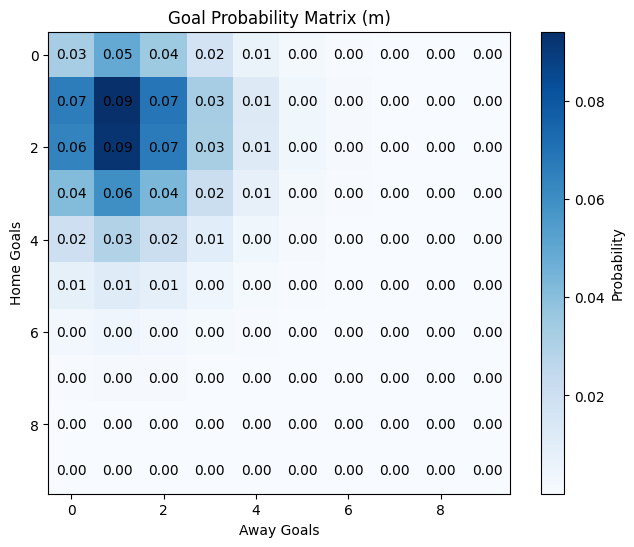

Under 1.5 goals: 0.1480, Over 1.5 goals: 0.8520
Under 2.5 goals: 0.3408, Over 2.5 goals: 0.6592
Under 3.5 goals: 0.5596, Over 3.5 goals: 0.4404

Match Outcome Odds (Decimal):
Home Win: 2.02
Draw: 4.57
Away Win: 3.48

Over/Under Goals Odds (Decimal):
Under 1.5 goals: 6.76, Over 1.5 goals: 1.17
Under 2.5 goals: 2.93, Over 2.5 goals: 1.52
Under 3.5 goals: 1.79, Over 3.5 goals: 2.27


(0.49392802562770116,
 0.21869458000896522,
 0.28733700162707587,
 {1.5: {'Under': 0.14798433992684304, 'Over': 0.852015660073157},
  2.5: {'Under': 0.34081638668916336, 'Over': 0.6591836133108366},
  3.5: {'Under': 0.5595760864090376, 'Over': 0.44042391359096245}})

In [386]:
predict(model_params,'Tottenham','Aston Villa')

In [608]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

def predict_ST(params, home_team, away_team, team_shot_thresholds=None, total_shot_thresholds=None):
    """
    Predicts the number of shots for home and away teams using a Poisson model,
    calculates probabilities for over/under shot thresholds, and determines
    which team is more likely to have more shots.

    Parameters:
    - params (dict): Model parameters including attack and defence strengths,
                     home advantage, and rho for correlation.
    - home_team (str): Name of the home team.
    - away_team (str): Name of the away team.
    - team_shot_thresholds (list): List of thresholds for individual team shots.
    - total_shot_thresholds (list): List of thresholds for total shots.

    Returns:
    - home_shots_prob (float): Probability of home team having more shots.
    - draw_shots_prob (float): Probability of a draw in shots.
    - away_shots_prob (float): Probability of away team having more shots.
    - over_under_shots_team (dict): Over/Under probabilities for specified thresholds per team.
    - over_under_shots_total (dict): Over/Under probabilities for specified thresholds total shots.
    """
    # Set default thresholds if none provided
    if team_shot_thresholds is None:
        team_shot_thresholds = [3, 5, 7, 9]  # Default thresholds for individual teams
    if total_shot_thresholds is None:
        total_shot_thresholds = [5.5, 7.5, 9.5, 11.5]  # Default thresholds for total shots

    # Extract parameters
    home_attack = params.get("attack_" + home_team, 0)
    home_defence = params.get("defence_" + home_team, 0)
    away_attack = params.get("attack_" + away_team, 0)
    away_defence = params.get("defence_" + away_team, 0)
    home_advantage = params.get("home_adv", 0)
    rho = params.get("rho", 0)  # Correlation parameter for shots

    # Calculate expected shots using exponential to ensure positivity
    home_shot_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_shot_expectation = np.exp(away_attack + home_defence)

    # Poisson probabilities for shots from 0 to max_shots
    max_shots = 25  # Adjust as needed
    shot_range = np.arange(0, max_shots + 1)
    home_probs = poisson.pmf(shot_range, home_shot_expectation)
    away_probs = poisson.pmf(shot_range, away_shot_expectation)

    # Shot probability matrix (Home Shots x Away Shots)
    m = np.outer(home_probs, away_probs)

    # Adjust for correlation (rho)
    # For a more accurate correlation adjustment, consider more sophisticated methods.
    if rho != 0:
        m[0, 0] *= 1 - home_shot_expectation * away_shot_expectation * rho
        m[0, 1] *= 1 + home_shot_expectation * rho
        m[1, 0] *= 1 + away_shot_expectation * rho
        m[1, 1] *= 1 - rho

    # Ensure all probabilities are non-negative and normalize
    m = np.maximum(m, 0)
    m /= m.sum()

    # Calculate Dominant Shot Probabilities
    home_shots_prob = np.sum(np.tril(m, -1))  # Home shots > Away shots
    draw_shots_prob = np.sum(np.diag(m))      # Home shots == Away shots
    away_shots_prob = np.sum(np.triu(m, 1))   # Away shots > Home shots

    # Calculate Over/Under Shot Probabilities for Each Team
    def over_under_team_prob(probs, threshold):
        # Under probability: P(shots <= threshold)
        under_prob = np.sum(probs[:int(np.floor(threshold)) + 1])
        over_prob = 1 - under_prob
        return under_prob, over_prob

    over_under_shots_team = {home_team: {}, away_team: {}}

    for threshold in team_shot_thresholds:
        # Home team probabilities
        under_prob_home, over_prob_home = over_under_team_prob(home_probs, threshold)
        over_under_shots_team[home_team][threshold] = {
            'Under': under_prob_home,
            'Over': over_prob_home
        }

        # Away team probabilities
        under_prob_away, over_prob_away = over_under_team_prob(away_probs, threshold)
        over_under_shots_team[away_team][threshold] = {
            'Under': under_prob_away,
            'Over': over_prob_away
        }

    # Calculate Over/Under Shot Probabilities for Total Shots
    def over_under_total_prob(m, threshold):
        total_probs = np.zeros((2 * max_shots) + 1)
        for i in range(max_shots + 1):
            for j in range(max_shots + 1):
                total_probs[i + j] += m[i, j]
        # Under probability: P(total shots <= threshold)
        under_prob = np.sum(total_probs[:int(np.floor(threshold)) + 1])
        over_prob = 1 - under_prob
        return under_prob, over_prob

    over_under_shots_total = {}
    for threshold in total_shot_thresholds:
        under_prob_total, over_prob_total = over_under_total_prob(m, threshold)
        over_under_shots_total[threshold] = {
            'Under': under_prob_total,
            'Over': over_prob_total
        }

    # Optional: Print Cheat Sheet (Comment out if not needed)
    """
    print(f'{home_team} VS {away_team} - Shots Prediction Cheat Sheet')
    print('============================================================')
    print(f'Probability {home_team} has more shots: {home_shots_prob:.4f}')
    print(f'Probability of a draw in shots: {draw_shots_prob:.4f}')
    print(f'Probability {away_team} has more shots: {away_shots_prob:.4f}')

    # Over/Under odds for shots per team
    print("\nOver/Under Shots Per Team:")
    for threshold in team_shot_thresholds:
        print(f"\nThreshold {threshold} Shots:")
        print(f"{home_team} - Under {threshold} shots: {over_under_shots_team[home_team][threshold]['Under']:.4f}, Over {threshold} shots: {over_under_shots_team[home_team][threshold]['Over']:.4f}")
        print(f"{away_team} - Under {threshold} shots: {over_under_shots_team[away_team][threshold]['Under']:.4f}, Over {threshold} shots: {over_under_shots_team[away_team][threshold]['Over']:.4f}")

    # Over/Under odds for total shots
    print("\nOver/Under Total Shots:")
    for threshold in total_shot_thresholds:
        print(f"Under {threshold} total shots: {over_under_shots_total[threshold]['Under']:.4f}, Over {threshold} total shots: {over_under_shots_total[threshold]['Over']:.4f}")
    """

    # Optional: Plotting the Shot Probability Matrix (Comment out if not needed)
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(m, cmap='Greens', interpolation='nearest')
    plt.colorbar(label='Probability')
    plt.xlabel(f"{away_team} Shots")
    plt.ylabel(f"{home_team} Shots")
    plt.title(f"Shot Probability Matrix: {home_team} vs {away_team}")

    # Display the values in each cell (optional for large matrices, may clutter)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m[i, j] > 0.001:  # Only display significant probabilities
                plt.text(j, i, f"{m[i, j]:.3f}", ha='center', va='center', color="black", fontsize=6)

    plt.show()
    """

    return home_shots_prob, draw_shots_prob, away_shots_prob, over_under_shots_team, over_under_shots_total


In [554]:
import numpy as np
import pandas as pd

def evaluate_over_under(matches_df, params, shot_thresholds=[5.5, 7.5, 9.5, 11.5]):
    """
    Evaluates the accuracy and log loss of over/under shot predictions for specified thresholds.

    Parameters:
    - matches_df (pd.DataFrame): DataFrame containing match data with columns ['HomeTeam', 'AwayTeam', 'HST', 'AST'].
    - params (dict): Dictionary of model parameters.
    - shot_thresholds (list): List of shot thresholds to evaluate.

    Returns:
    - results (dict): Dictionary containing evaluation metrics for each threshold.
    """
    # Initialize metrics storage
    results = {}
    epsilon = 1e-15  # To prevent log(0)

    # Initialize metrics for each threshold
    metrics = {threshold: {'correct_predictions': 0,
                           'total_predictions': 0,
                           'log_loss': 0.0,
                           'brier_score': 0.0} for threshold in shot_thresholds}

    for index, row in matches_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        actual_home_shots = row['HST']
        actual_away_shots = row['AST']

        # Calculate total shots
        total_shots = actual_home_shots + actual_away_shots

        # Get predicted probabilities
        home_prob, draw_prob, away_prob, over_under_shots_team, over_under_shots_total = predict_ST(
            params, home_team, away_team, total_shot_thresholds=shot_thresholds)

        for threshold in shot_thresholds:
            # Determine actual outcome
            actual_outcome = 'Over' if total_shots > threshold else 'Under'

            # Get model's over/under probabilities for the current threshold
            if threshold not in over_under_shots_total:
                print(f"Threshold {threshold} not found in over_under_shots_total. Skipping.")
                continue

            over_prob = over_under_shots_total[threshold]['Over']
            under_prob = over_under_shots_total[threshold]['Under']

            # Make prediction based on higher probability
            predicted_outcome = 'Over' if over_prob > under_prob else 'Under'
            predicted_prob = over_prob if over_prob > under_prob else under_prob

            # Update total predictions
            metrics[threshold]['total_predictions'] += 1

            # Check if prediction is correct
            if predicted_outcome == actual_outcome:
                metrics[threshold]['correct_predictions'] += 1

            # Update Log Loss
            if actual_outcome == 'Over':
                log_loss_contrib = -np.log(over_prob + epsilon)
            else:
                log_loss_contrib = -np.log(under_prob + epsilon)
            metrics[threshold]['log_loss'] += log_loss_contrib

            # Update Brier Score
            y = 1 if actual_outcome == 'Over' else 0
            p = over_prob  # Probability of "Over"
            brier_score_contrib = (p - y) ** 2
            metrics[threshold]['brier_score'] += brier_score_contrib

    # Calculate metrics for each threshold
    for threshold in shot_thresholds:
        total_predictions = metrics[threshold]['total_predictions']
        if total_predictions > 0:
            accuracy = metrics[threshold]['correct_predictions'] / total_predictions
            average_log_loss = metrics[threshold]['log_loss'] / total_predictions
            average_brier_score = metrics[threshold]['brier_score'] / total_predictions
        else:
            accuracy = None
            average_log_loss = None
            average_brier_score = None

        # Store results
        results[threshold] = {
            'Accuracy': accuracy,
            'Average Log Loss': average_log_loss,
            'Average Brier Score': average_brier_score,
            'Total Predictions': total_predictions
        }

        # Print results for the threshold
        print(f"Threshold: {threshold} Shots")
        print(f"Accuracy: {accuracy:.2%}" if accuracy is not None else "Accuracy: N/A")
        print(f"Average Log Loss: {average_log_loss:.4f}" if average_log_loss is not None else "Average Log Loss: N/A")
        print(f"Average Brier Score: {average_brier_score:.4f}" if average_brier_score is not None else "Average Brier Score: N/A")
        print(f"Total Predictions: {total_predictions}\n")

    return results


In [563]:
import numpy as np
import pandas as pd

def evaluate_over_under(
    matches_df,
    params,
    total_shot_thresholds=[5.5, 7.5, 9.5, 11.5],
    team_shot_thresholds=[3, 5, 7, 9],
    confidence_threshold=0.7
):
    """
    Evaluates the accuracy and log loss of over/under shot predictions for specified thresholds,
    for both total shots and individual team shots.

    Parameters:
    - matches_df (pd.DataFrame): DataFrame containing match data with columns ['HomeTeam', 'AwayTeam', 'HST', 'AST'].
    - params (dict): Dictionary of model parameters.
    - total_shot_thresholds (list): List of total shot thresholds to evaluate.
    - team_shot_thresholds (list): List of team-specific shot thresholds to evaluate.
    - confidence_threshold (float): Minimum confidence level to consider a prediction.

    Returns:
    - results (dict): Dictionary containing evaluation metrics for each threshold.
    """
    # Initialize metrics storage
    results = {
        'total_shots': {},
        'team_shots': {}
    }
    epsilon = 1e-15  # To prevent log(0)

    # Initialize metrics for total shot thresholds
    total_metrics = {threshold: {'correct_predictions': 0,
                                 'total_predictions': 0,
                                 'log_loss': 0.0,
                                 'brier_score': 0.0} for threshold in total_shot_thresholds}

    # Initialize metrics for team-specific thresholds
    team_metrics = {}
    for team in matches_df['HomeTeam'].unique().tolist() + matches_df['AwayTeam'].unique().tolist():
        team_metrics[team] = {threshold: {'correct_predictions': 0,
                                          'total_predictions': 0,
                                          'log_loss': 0.0,
                                          'brier_score': 0.0} for threshold in team_shot_thresholds}

    for index, row in matches_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        actual_home_shots = row['HST']
        actual_away_shots = row['AST']

        # Calculate total shots
        total_shots = actual_home_shots + actual_away_shots

        # Get predicted probabilities
        home_prob, draw_prob, away_prob, over_under_shots_team, over_under_shots_total = predict_ST(
            params,
            home_team,
            away_team,
            team_shot_thresholds=team_shot_thresholds,
            total_shot_thresholds=total_shot_thresholds
        )

        # Evaluate total shot thresholds
        for threshold in total_shot_thresholds:
            # Determine actual outcome
            actual_outcome = 'Over' if total_shots > threshold else 'Under'

            # Get model's over/under probabilities for the current threshold
            if threshold not in over_under_shots_total:
                print(f"Threshold {threshold} not found in over_under_shots_total. Skipping.")
                continue

            over_prob = over_under_shots_total[threshold]['Over']
            under_prob = over_under_shots_total[threshold]['Under']

            # Determine predicted outcome and confidence
            if over_prob > under_prob:
                predicted_outcome = 'Over'
                predicted_prob = over_prob
            else:
                predicted_outcome = 'Under'
                predicted_prob = under_prob

            # Check if the predicted probability meets the confidence threshold
            if predicted_prob >= confidence_threshold:
                # Update total predictions
                total_metrics[threshold]['total_predictions'] += 1

                # Check if prediction is correct
                if predicted_outcome == actual_outcome:
                    total_metrics[threshold]['correct_predictions'] += 1

                # Update Log Loss
                if actual_outcome == 'Over':
                    log_loss_contrib = -np.log(over_prob + epsilon)
                else:
                    log_loss_contrib = -np.log(under_prob + epsilon)
                total_metrics[threshold]['log_loss'] += log_loss_contrib

                # Update Brier Score
                y = 1 if actual_outcome == 'Over' else 0
                p = over_prob  # Probability of "Over"
                brier_score_contrib = (p - y) ** 2
                total_metrics[threshold]['brier_score'] += brier_score_contrib
            else:
                continue  # Skip predictions below confidence threshold

        # Evaluate team-specific thresholds for the home team
        for threshold in team_shot_thresholds:
            # Determine actual outcome for home team
            actual_outcome_home = 'Over' if actual_home_shots > threshold else 'Under'

            # Get model's over/under probabilities for the home team
            over_prob_home = over_under_shots_team[home_team][threshold]['Over']
            under_prob_home = over_under_shots_team[home_team][threshold]['Under']

            # Determine predicted outcome and confidence
            if over_prob_home > under_prob_home:
                predicted_outcome_home = 'Over'
                predicted_prob_home = over_prob_home
            else:
                predicted_outcome_home = 'Under'
                predicted_prob_home = under_prob_home

            # Check if the predicted probability meets the confidence threshold
            if predicted_prob_home >= confidence_threshold:
                # Update total predictions
                team_metrics[home_team][threshold]['total_predictions'] += 1

                # Check if prediction is correct
                if predicted_outcome_home == actual_outcome_home:
                    team_metrics[home_team][threshold]['correct_predictions'] += 1

                # Update Log Loss
                if actual_outcome_home == 'Over':
                    log_loss_contrib_home = -np.log(over_prob_home + epsilon)
                else:
                    log_loss_contrib_home = -np.log(under_prob_home + epsilon)
                team_metrics[home_team][threshold]['log_loss'] += log_loss_contrib_home

                # Update Brier Score
                y_home = 1 if actual_outcome_home == 'Over' else 0
                p_home = over_prob_home  # Probability of "Over"
                brier_score_contrib_home = (p_home - y_home) ** 2
                team_metrics[home_team][threshold]['brier_score'] += brier_score_contrib_home

        # Evaluate team-specific thresholds for the away team
        for threshold in team_shot_thresholds:
            # Determine actual outcome for away team
            actual_outcome_away = 'Over' if actual_away_shots > threshold else 'Under'

            # Get model's over/under probabilities for the away team
            over_prob_away = over_under_shots_team[away_team][threshold]['Over']
            under_prob_away = over_under_shots_team[away_team][threshold]['Under']

            # Determine predicted outcome and confidence
            if over_prob_away > under_prob_away:
                predicted_outcome_away = 'Over'
                predicted_prob_away = over_prob_away
            else:
                predicted_outcome_away = 'Under'
                predicted_prob_away = under_prob_away

            # Check if the predicted probability meets the confidence threshold
            if predicted_prob_away >= confidence_threshold:
                # Update total predictions
                team_metrics[away_team][threshold]['total_predictions'] += 1

                # Check if prediction is correct
                if predicted_outcome_away == actual_outcome_away:
                    team_metrics[away_team][threshold]['correct_predictions'] += 1

                # Update Log Loss
                if actual_outcome_away == 'Over':
                    log_loss_contrib_away = -np.log(over_prob_away + epsilon)
                else:
                    log_loss_contrib_away = -np.log(under_prob_away + epsilon)
                team_metrics[away_team][threshold]['log_loss'] += log_loss_contrib_away

                # Update Brier Score
                y_away = 1 if actual_outcome_away == 'Over' else 0
                p_away = over_prob_away  # Probability of "Over"
                brier_score_contrib_away = (p_away - y_away) ** 2
                team_metrics[away_team][threshold]['brier_score'] += brier_score_contrib_away

    # Calculate metrics for total shot thresholds
    print("Total Shot Thresholds Evaluation:")
    for threshold in total_shot_thresholds:
        total_predictions = total_metrics[threshold]['total_predictions']
        if total_predictions > 0:
            accuracy = total_metrics[threshold]['correct_predictions'] / total_predictions
            average_log_loss = total_metrics[threshold]['log_loss'] / total_predictions
            average_brier_score = total_metrics[threshold]['brier_score'] / total_predictions
        else:
            accuracy = None
            average_log_loss = None
            average_brier_score = None

        # Store results
        results['total_shots'][threshold] = {
            'Accuracy': accuracy,
            'Average Log Loss': average_log_loss,
            'Average Brier Score': average_brier_score,
            'Total Predictions': total_predictions
        }

        # Print results for the threshold
        print(f"\nThreshold: {threshold} Total Shots")
        print(f"Accuracy: {accuracy:.2%}" if accuracy is not None else "Accuracy: N/A")
        print(f"Average Log Loss: {average_log_loss:.4f}" if average_log_loss is not None else "Average Log Loss: N/A")
        print(f"Average Brier Score: {average_brier_score:.4f}" if average_brier_score is not None else "Average Brier Score: N/A")
        print(f"Total Predictions (Confidence ≥ {confidence_threshold}): {total_predictions}")

    # Calculate metrics for team-specific thresholds
    print("\nTeam-Specific Shot Thresholds Evaluation:")
    for team in team_metrics:
        print(f"\nTeam: {team}")
        for threshold in team_shot_thresholds:
            total_predictions = team_metrics[team][threshold]['total_predictions']
            if total_predictions > 0:
                accuracy = team_metrics[team][threshold]['correct_predictions'] / total_predictions
                average_log_loss = team_metrics[team][threshold]['log_loss'] / total_predictions
                average_brier_score = team_metrics[team][threshold]['brier_score'] / total_predictions
            else:
                accuracy = None
                average_log_loss = None
                average_brier_score = None

            # Store results
            if team not in results['team_shots']:
                results['team_shots'][team] = {}
            results['team_shots'][team][threshold] = {
                'Accuracy': accuracy,
                'Average Log Loss': average_log_loss,
                'Average Brier Score': average_brier_score,
                'Total Predictions': total_predictions
            }

            # Print results for the threshold
            print(f"  Threshold: {threshold} Shots")
            print(f"    Accuracy: {accuracy:.2%}" if accuracy is not None else "    Accuracy: N/A")
            print(f"    Average Log Loss: {average_log_loss:.4f}" if average_log_loss is not None else "    Average Log Loss: N/A")
            print(f"    Average Brier Score: {average_brier_score:.4f}" if average_brier_score is not None else "    Average Brier Score: N/A")
            print(f"    Total Predictions (Confidence ≥ {confidence_threshold}): {total_predictions}")

    return results


In [567]:
results = evaluate_over_under(
    df3,
    model_params_ST,
    total_shot_thresholds=[5.5, 7.5, 9.5, 11.5],
    team_shot_thresholds=[3, 5, 7, 9],
    confidence_threshold=0.9
)

Total Shot Thresholds Evaluation:

Threshold: 5.5 Total Shots
Accuracy: 87.45%
Average Log Loss: 0.4476
Average Brier Score: 0.1168
Total Predictions (Confidence ≥ 0.9): 271

Threshold: 7.5 Total Shots
Accuracy: 70.42%
Average Log Loss: 0.9094
Average Brier Score: 0.2643
Total Predictions (Confidence ≥ 0.9): 71

Threshold: 9.5 Total Shots
Accuracy: 65.22%
Average Log Loss: 1.1420
Average Brier Score: 0.3173
Total Predictions (Confidence ≥ 0.9): 23

Threshold: 11.5 Total Shots
Accuracy: 59.09%
Average Log Loss: 1.1043
Average Brier Score: 0.3519
Total Predictions (Confidence ≥ 0.9): 22

Team-Specific Shot Thresholds Evaluation:

Team: Crystal Palace
  Threshold: 3 Shots
    Accuracy: 50.00%
    Average Log Loss: 1.5223
    Average Brier Score: 0.4529
    Total Predictions (Confidence ≥ 0.9): 2
  Threshold: 5 Shots
    Accuracy: 100.00%
    Average Log Loss: 0.0580
    Average Brier Score: 0.0032
    Total Predictions (Confidence ≥ 0.9): 2
  Threshold: 7 Shots
    Accuracy: 88.89%
    Av

In [611]:
import numpy as np
import pandas as pd

def evaluate_shot_dominance_predictions(matches_df, params, confidence_threshold=0.65):
    """
    Evaluates the accuracy of the model's predictions of which team will have more shots on target,
    considering only predictions where the model's confidence is above the specified threshold.

    Parameters:
    - matches_df (pd.DataFrame): DataFrame containing match data with columns ['HomeTeam', 'AwayTeam', 'HST', 'AST'].
    - params (dict): Dictionary of model parameters.
    - confidence_threshold (float): Minimum confidence level to consider a prediction.

    Returns:
    - results (dict): Dictionary containing evaluation metrics.
    """
    # Initialize counters
    total_predictions = 0
    correct_predictions = 0
    incorrect_predictions = 0

    # Optional: Collect detailed results
    detailed_results = []

    for index, row in matches_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        actual_home_shots = row['HST']
        actual_away_shots = row['AST']

        # Get actual outcome
        if actual_home_shots > actual_away_shots:
            actual_outcome = 'HomeWin'
        elif actual_home_shots < actual_away_shots:
            actual_outcome = 'AwayWin'
        else:
            actual_outcome = 'Draw'

        # Get predicted probabilities
        home_prob, draw_prob, away_prob, over_under_shots_team, over_under_shots_total = predict_ST(
            params, home_team, away_team)

        # Determine predicted outcome and confidence
        probs = {'HomeWin': home_prob, 'Draw': draw_prob, 'AwayWin': away_prob}
        predicted_outcome = max(probs, key=probs.get)
        confidence = probs[predicted_outcome]

        # Check if confidence meets threshold
        if confidence >= confidence_threshold:
            total_predictions += 1

            # Check if prediction is correct
            if predicted_outcome == actual_outcome:
                correct_predictions += 1
                result = 'Correct'
            else:
                incorrect_predictions += 1
                result = 'Incorrect'

            # Optional: Store detailed results
            detailed_results.append({
                'Match': f"{home_team} vs {away_team}",
                'Predicted Outcome': predicted_outcome,
                'Actual Outcome': actual_outcome,
                'Confidence': confidence,
                'Result': result
            })

    # Calculate accuracy
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
    else:
        accuracy = None

    # Print results
    print(f"Shot Dominance Prediction Results (Confidence ≥ {confidence_threshold}):")
    if accuracy is not None:
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Total Predictions: {total_predictions}")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Incorrect Predictions: {incorrect_predictions}")
    else:
        print("No predictions made with the specified confidence threshold.")

    # Return results
    results = {
        'Accuracy': accuracy,
        'Total Predictions': total_predictions,
        'Correct Predictions': correct_predictions,
        'Incorrect Predictions': incorrect_predictions,
        'Detailed Results': detailed_results  # Optional
    }

    return results


In [615]:
# Example usage
results = evaluate_shot_dominance_predictions(df5, model_params_ST, confidence_threshold=0.8)


Shot Dominance Prediction Results (Confidence ≥ 0.8):
Accuracy: 75.00%
Total Predictions: 24
Correct Predictions: 18
Incorrect Predictions: 6
